# Module 02: Modeling Process

## Prerequisites

This module leverages the following packages.

In [1]:
# Helper packages
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_density, geom_line, geom_point, ggtitle
import math

# Modeling preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline

# Modeling and resampling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

Data used:

In [2]:
# Ames housing data
ames = pd.read_csv("https://koalaverse.github.io/homlr/data/ames.csv")

# Job attrition data
attrition = pd.read_csv("https://koalaverse.github.io/homlr/data/attrition.csv")

## Data splitting

### Simple random sampling

In [3]:
train, test = train_test_split(ames, test_size=0.3, random_state=123)

In [4]:
f"raw data dimensions: {ames.shape}; training dimensions: {train.shape}; testing dimensions:  {test.shape}"

'raw data dimensions: (2930, 81); training dimensions: (2051, 81); testing dimensions:  (879, 81)'

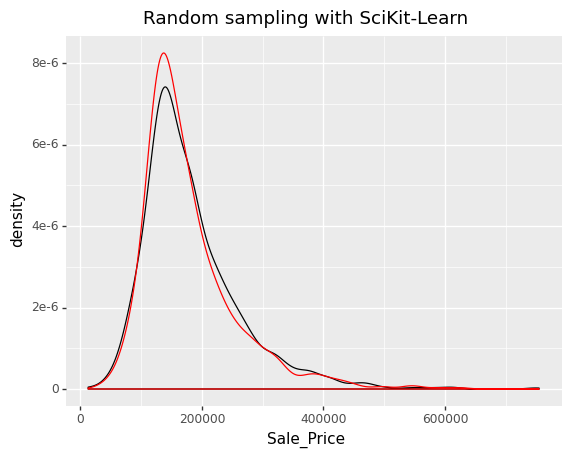

<ggplot: (-9223372036573046994)>

In [5]:
(ggplot(train, aes('Sale_Price'))
 + geom_density()
 + geom_density(data = test, color = "red")
 + ggtitle("Random sampling with SciKit-Learn"))

### Stratified sampling

In [6]:
y = attrition["Attrition"]
train_strat, test_strat = train_test_split(attrition, test_size=0.3, random_state=123, stratify=y)

In [7]:
# response distribution for raw data
attrition["Attrition"].value_counts(normalize=True)

No     0.838776
Yes    0.161224
Name: Attrition, dtype: float64

In [8]:
# response distribution for training data
train_strat["Attrition"].value_counts(normalize=True)

No     0.838678
Yes    0.161322
Name: Attrition, dtype: float64

In [9]:
# response distribution for test data
test_strat["Attrition"].value_counts(normalize=True)

No     0.839002
Yes    0.160998
Name: Attrition, dtype: float64

## Putting the processes together

In [10]:
# Sample data
train, test = train_test_split(ames, test_size=0.3, random_state=123)

# Extract features and response
features = train.drop(columns="Sale_Price")
label = train["Sale_Price"]

In [11]:
# SciKit-Learn does not automatically transform categorical features so we need to 
# apply a one-hot transformer. We will discuss this more thoroughly in the next chapter.
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, selector(dtype_include="object"))])

knn_fit = Pipeline(steps=[('preprocessor', preprocessor),
                          ('knn', KNeighborsRegressor(metric='euclidean'))])

In [12]:
# Specify resampling strategy
cv = RepeatedKFold(n_splits=10, n_repeats=5)

# Create grid of hyperparameter values
hyper_grid = {'knn__n_neighbors': range(3, 26)}

# Tune a knn model using grid search
grid_search = GridSearchCV(knn_fit, hyper_grid, cv=cv, scoring='neg_mean_squared_error')
results = grid_search.fit(features, label)

In [13]:
# Best model's cross validated RMSE
math.sqrt(abs(results.best_score_))

38584.169418505626

In [14]:
# Best model's k value
results.best_estimator_.get_params().get('knn__n_neighbors')

6

In [15]:
# All RMSE results
np.sqrt(np.abs(results.cv_results_['mean_test_score']))

array([39189.90775966, 39103.08720692, 38734.30014262, 38584.16941851,
       38635.86326272, 38743.85871455, 38995.52986058, 39029.25912836,
       39157.23551651, 39308.16301926, 39431.00624581, 39560.82190429,
       39672.23488913, 39767.03588456, 39868.9365836 , 39997.32833458,
       40068.32142513, 40150.30820974, 40182.2215066 , 40296.64118505,
       40394.08662001, 40460.42829976, 40523.95171425])

In [16]:
# Plot all RMSE results
all_rmse = pd.DataFrame({'k': range(3, 26), 'RMSE': np.sqrt(np.abs(results.cv_results_['mean_test_score']))})


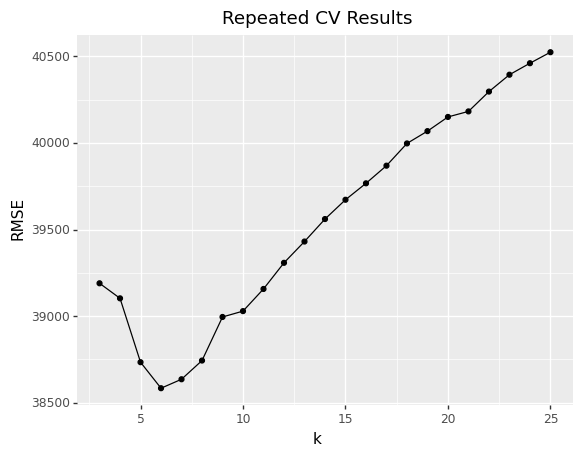

<ggplot: (-9223372036542143509)>

In [17]:
(ggplot(all_rmse, aes(x='k', y='RMSE'))
 + geom_line()
 + geom_point()
 + ggtitle("Repeated CV Results"))